In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import json
from os import listdir
from os.path import join
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from xgboost import XGBClassifier
from sklearn.metrics.pairwise import cosine_similarity

# Load data & Sentence embeddings

You can get model on https://tfhub.dev/google/universal-sentence-encoder/1

In [3]:
embed = hub.Module("/home/yarik/Documents/Python/Emotions/embedding_model")

Instructions for updating:
Colocations handled automatically by placer.


W1007 21:38:39.044237 139858999334720 deprecation.py:323] From /home/yarik/anaconda3/envs/textai/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [4]:
def get_embeddings(sentences):
    tf.logging.set_verbosity(tf.logging.ERROR)
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        return session.run(embed(sentences))

# Amazon data set
link: http://jmcauley.ucsd.edu/data/amazon/
Selected categories for the example cell phones and accessories, electronics, video games, office products, clothing

In [65]:
categories_names = {'reviews_Cell_Phones_and_Accessories_5.json':'phone_accessories',
                    'reviews_Electronics_5.json':'electronics',
                    'reviews_Video_Games_5.json': 'video_games',
                    'reviews_Clothing_Shoes_and_Jewelry_5.json':'cloth',
                    'reviews_Office_Products_5.json':'office_products'}
reviews = pd.DataFrame()

for file in listdir('/home/yarik/Documents/Data/Amazon_reviews'):
    with open(join('/home/yarik/Documents/Data/Amazon_reviews',file)) as json_file:
        file_data = pd.DataFrame.from_records(map(json.loads,json_file.readlines()),nrows=10000)
    file_data['category'] = [categories_names[file]] * len(file_data)
    
    reviews = pd.concat([file_data[['summary','category']], reviews],ignore_index=True)

In [10]:
sample_sentences = ["how old are you?", "what is your age?", "my phone doesn't work", "my phone is destroy"]

In [11]:
sample_embeddings = get_embeddings(sample_sentences)

In [12]:
similarity = cosine_similarity(sample_embeddings)

In [13]:
similarity

array([[0.9999997 , 0.90705013, 0.0515891 , 0.05542911],
       [0.90705013, 1.0000006 , 0.06356009, 0.07294559],
       [0.0515891 , 0.06356009, 1.        , 0.82998157],
       [0.05542911, 0.07294559, 0.82998157, 1.        ]], dtype=float32)

# split train and test

In [67]:
reviews.shape

(50000, 2)

In [68]:
train, test = train_test_split(reviews, test_size=0.2)

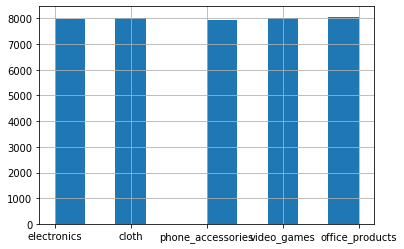

In [69]:
train['category'].hist()

# Vector space representation

In [70]:
train_vectors = get_embeddings(train.summary.apply(str).to_list())

In [71]:
test_vectors = get_embeddings(test.summary.apply(str).to_list())

In [72]:
train_vectors.shape

(40000, 512)

# Classifier
## LR

In [73]:
clf = LogisticRegression(random_state=0,
                         multi_class='multinomial',
                         solver='lbfgs').fit(train_vectors, train['category'])

/home/yarik/anaconda3/envs/textai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [74]:
LR_predictions = clf.predict(test_vectors)
confusion_matrix(LR_predictions, test['category']),f1_score(LR_predictions, test['category'], average="weighted")

(array([[1451,  155,  164,  216,   85],
        [ 134, 1025,  244,  394,   92],
        [ 134,  270, 1248,  198,   47],
        [ 171,  431,  201, 1141,  104],
        [ 108,  127,   80,  114, 1666]]), 0.6549699313112824)

# XGBoost

In [77]:
clf_xgboost = XGBClassifier(max_depth=10,
                              n_jobs=8,
                              n_estimators=200,
                              objective='multi:softmax').fit(train_vectors, train['category'])

In [78]:
Xgboost_predictions = clf_xgboost.predict(test_vectors)

In [79]:
confusion_matrix(Xgboost_predictions, test['category']),f1_score(Xgboost_predictions,
                                                                 test['category'],
                                                                 average="weighted")

(array([[1480,  162,  149,  204,   75],
        [ 129, 1128,  260,  434,  109],
        [ 141,  235, 1268,  158,   63],
        [ 154,  377,  204, 1176,  110],
        [  94,  106,   56,   91, 1637]]), 0.6689391785689278)

# Neural Network

In [80]:
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.utils import to_categorical

Using TensorFlow backend.


In [82]:
def encond_labels(pd_serie,dic_label):
    dic_label = pd_serie.replace(dic_label)
    return to_categorical(dic_label,dtype='int')

dic_enconde = {word:index for index,word in enumerate((test['category'].unique()))}

In [84]:
#Encode y_train & y_test
y_train_encode = encond_labels(train['category'],dic_enconde)
y_test_encode = encond_labels(test['category'],dic_enconde)

In [88]:
input_dim = len(train_vectors[0])
output_dim = len(y_test_encode[0])

In [89]:
input_dim = len(train_vectors[0])
output_dim = len(y_test_encode[0])

nn_model = Sequential()
nn_model.add(Dense(input_dim,input_dim = input_dim, activation = 'relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(600, activation = 'relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(300, activation = 'relu'))
nn_model.add(Dense(output_dim, activation='softmax'))

nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
nn_model.summary()

nn_model.fit(train_vectors,y_train_encode,epochs=30, batch_size=1000, validation_split= .1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 600)               307800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               180300    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1505      
Total params: 752,261
Trainable params: 752,261
Non-trainable params: 0
_________________________________________________________________
Trai

In [92]:
nn_predictions = nn_model.predict_classes(test_vectors)
confusion_matrix(nn_predictions, test['category'].replace(dic_enconde)),f1_score(nn_predictions, test['category'].replace(dic_enconde), average="weighted")

(array([[1212,  211,  216,  413,  124],
        [ 187, 1464,  130,  130,   55],
        [ 129,   97, 1227,  169,   27],
        [ 446,  145,  302, 1195,  105],
        [  89,   81,   62,  101, 1683]]), 0.6764804766012932)

# Multiple classifier

In [105]:
# join predictons train
multinomial= clf.predict_proba(train_vectors)
nn = nn_model.predict_proba(train_vectors)
xgboost = clf_xgboost.predict_proba(train_vectors)

In [106]:
concatenate_predictions= np.concatenate((multinomial,nn,xgboost), axis=1)

In [107]:
clf_xgboost_boosting  = XGBClassifier(max_depth=5,
                                      n_jobs=8,
                                      n_estimators=200,
                                      objective='multi:softmax').fit(concatenate_predictions, train['category'])

In [108]:
# join prediction test
multinomial_test= clf.predict_proba(test_vectors)
nn_test = nn_model.predict_proba(test_vectors)
xgboost_test = clf_xgboost.predict_proba(test_vectors)
concatenate_predictions_test = np.concatenate((multinomial_test,nn_test,xgboost_test), axis=1)

In [109]:
concatenate_predictions_test.shape

(10000, 15)

In [110]:
Xgboost_predictions_boosting = clf_xgboost_boosting.predict(concatenate_predictions_test)
confusion_matrix(Xgboost_predictions_boosting, test['category']),f1_score(Xgboost_predictions_boosting,
                                                                         test['category'],
                                                                         average="weighted")

(array([[1487,  179,  162,  214,   82],
        [ 125, 1117,  250,  444,   97],
        [ 154,  255, 1281,  190,   86],
        [ 144,  355,  190, 1132,  100],
        [  88,  102,   54,   83, 1629]]), 0.6651863847750071)